In [1]:
import numpy as np
import matplotlib.pyplot as plt
import fitsio
from astropy.table import Table
import healpy as hp
from GetObjects import *
import Config

In [2]:
from ugali.analysis.isochrone import factory as isochrone_factory
from matplotlib.path import Path
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection

def mkpol(mu, age=12., z=0.0004, dmu=0.5, C=[0.05, 0.05], E=4., err=None, survey='DECaLS', clip=None):
    if err == None:
        print('Using DES err!')
        err = surveys.surveys['DES_DR1']['err']
    """ Builds ordered polygon for masking """

    iso = isochrone_factory('Bressan2012', survey='des',
                            age=age, distance_modulus=mu, z=z)
    c = iso.color
    m = iso.mag

    # clip=4
    # clip = 3.4
    if clip is not None:
        # Clip for plotting, use gmin otherwise
        # clip abs mag
        cut = (m > clip) & ((m + mu) < 240) & (c > 0) & (c < 1)
        c = c[cut]
        m = m[cut]

    mnear = m + mu - dmu / 2.
    mfar = m + mu + dmu / 2.
    C = np.r_[c + E * err(mfar) + C[1], c[::-1] -  E * err(mnear[::-1]) - C[0]]
    M = np.r_[m, m[::-1]]
    return np.c_[C, M],iso
err=lambda x: (0.0010908679647672335 + np.exp((x - 27.091072029215375) / 1.0904624484538419))

def feh2z( feh):
        # Section 3 of Dotter et al. 2008
        Y_p     = 0.245            # Primordial He abundance (WMAP, 2003)
        c       = 1.54             # He enrichment ratio 

        # This is not well defined...
        #Z_solar/X_solar = 0.0229  # Solar metal fraction (Grevesse 1998)
        ZX_solar = 0.0229
        return (1 - Y_p)/( (1 + c) + (1/ZX_solar) * 10**(-feh))
    
def dist_fu(ra):
    # given ra in deg return distance of 300s in kpc from fu et al.  
    return 48.9952-0.2083*ra

def dist2mod(dist):
    return np.log10(dist*1e3)*5-5

In [3]:
index = 38
condData = fitsio.read(Config.files[index])
condition = Config.conditions[index]
condPix = condData['PIXEL']
condSignal = condData['SIGNAL']

condPix = condPix[np.where(condSignal > -100)[0]]
condSignal = condSignal[np.where(condSignal > -100)[0]]

In [4]:
gCut = 37

detBalrStarFile = '/afs/hep.wisc.edu/bechtol-group/MegansThings/balrog_detection_catalog_sof_run2_stars_v1.4_avg_added_match_flags.fits'
detStarFile = '/hdfs/bechtol/balrog/y3/y3a2_survey_conditions_maps/Kyle_Stuff/MaximumLikelihood/StellarStreamFirstTest/BalrogStarData.fits'

detBalrFile = '/hdfs/bechtol/balrog/y3/balrog_detection_catalog_sof_y3-merged_v1.2.fits'
deepFiles = ['/hdfs/bechtol/balrog/y3_deep_fields/y3_deep_fields_catalog/deepfields_000001.fits', 
             '/hdfs/bechtol/balrog/y3_deep_fields/y3_deep_fields_catalog/deepfields_000002.fits', 
             '/hdfs/bechtol/balrog/y3_deep_fields/y3_deep_fields_catalog/deepfields_000003.fits',
             '/hdfs/bechtol/balrog/y3_deep_fields/y3_deep_fields_catalog/deepfields_000004.fits',
             '/hdfs/bechtol/balrog/y3_deep_fields/y3_deep_fields_catalog/deepfields_000005.fits']
detGalaFile = '/hdfs/bechtol/balrog/y3/y3a2_survey_conditions_maps/Kyle_Stuff/MaximumLikelihood/StellarStreamFirstTest/BalrogGalaxyData.fits'

mu = 16.2
age=12.8
feh=-2.5
z=feh2z(feh)
mk,iso=mkpol(mu,age,z,dmu=0.5,C=[0.01,0.1],E=2,err=err, survey="DES_Y3A2")#, clip=0.3)
pth=Path(mk)

# getDetGalas(pth, mu, deepFiles, detBalrFile, detGalaFile, gCut)
# getDetStar(pth, mu, detBalrStarFile, detStarFile, gCut)

In [5]:
starData = fitsio.read(detStarFile)
galaData = fitsio.read(detGalaFile)

In [6]:
isoDir = '/hdfs/bechtol/balrog/y3/y3a2_survey_conditions_maps/Kyle_Stuff/MaximumLikelihood/Isochrone_DistMod18.5_Class2.5_Res512/'

conditions = Config.conditions
pixFile = isoDir + 'PixAndConds/Valid_Pixels.fits'
condFiles = []
for cond in conditions:
    condFiles.append(isoDir + 'PixAndConds/' + cond + '.fits')
condFiles = np.array(condFiles)

# validPix = fitsio.read(pixFile)['PIXEL']
# pixCheck = np.full(12*(512**2), False, dtype = bool)
# pixCheck[validPix] = True

In [7]:
starRMAG = starData['RMAG']
starDET = np.zeros_like(starRMAG)
starDET[np.where((starData['CLASS'] <= 0) & (starData['CLASS'] >= 0))[0]] = 1
starRA = starData['RA']
starDEC = starData['DEC']
starPIX = hp.ang2pix(4096, starRA, starDEC, lonlat = True, nest = True)

galaRMAG = galaData['RMAG']
galaDET = np.zeros_like(galaRMAG)
galaDET[np.where((galaData['CLASS'] <= 0) & (galaData['CLASS'] >= 0))[0]] = 1
galaRA = galaData['RA']
galaDEC = galaData['DEC']
galaPIX = hp.ang2pix(4096, galaRA, galaDEC, lonlat = True, nest = True)

In [8]:
starPIX = starPIX[np.where(starDET == 1)[0]]
starRMAG = starRMAG[np.where(starDET == 1)[0]]

galaPIX = galaPIX[np.where(galaDET == 1)[0]]
galaRMAG = galaRMAG[np.where(galaDET == 1)[0]]

In [9]:
# pixCut = np.where(pixCheck[starPIX])[0]

# # starDET = starDET[pixCut]
# starPIX = starPIX[pixCut]
# starRMAG = starRMAG[pixCut]

In [10]:
# pixCut = np.where(pixCheck[galaPIX])[0]

# # galaDET = galaDET[pixCut]
# galaPIX = galaPIX[pixCut]
# galaRMAG = galaRMAG[pixCut]

In [11]:
sigma = 0.5
numBins = 100

In [12]:
# xStar = np.linspace(np.average(starRMAG)-3*np.std(starRMAG), np.average(starRMAG)+3*np.std(starRMAG), numBins)
# xStar = xStar[np.where(xStar <= np.max(starRMAG))[0]]
# starSigma = sigma * np.std(starRMAG)
# yStar = []

# for xi in xStar:
#     # Gaussian weighting the values close by to each x value.
#     totCor = np.sum(starDET * np.exp(-1*(((starRMAG - xi) / starSigma)**2)))
#     totAll = np.sum(np.exp(-1*(((starRMAG - xi) / starSigma)**2)))
#     yStar.append(totCor / totAll)

# yStar = np.array(yStar)

In [13]:
# xGala = np.linspace(np.average(galaRMAG)-3*np.std(galaRMAG), np.average(galaRMAG)+3*np.std(galaRMAG), numBins)
# xGala = xGala[np.where(xGala <= np.max(galaRMAG))[0]]
# galaSigma = sigma * np.std(galaRMAG)
# yGala = []

# for xi in xGala:
#     # Gaussian weighting the values close by to each x value.
#     totCor = np.sum(galaDET * np.exp(-1*(((galaRMAG - xi) / galaSigma)**2)))
#     totAll = np.sum(np.exp(-1*(((galaRMAG - xi) / galaSigma)**2)))
#     yGala.append(totCor / totAll)

# yGala = np.array(yGala)

In [14]:
# plt.figure(dpi = 120)
# plt.plot(xStar, yStar, zorder = 3, label = 'Star Stellar Detection Rate')
# plt.xlabel('r Band Magnitude')
# plt.ylabel('Percent')
# plt.legend()
# plt.grid(zorder = 0)
# # plt.ylim([0, 1])
# plt.show()

In [15]:
# plt.figure(dpi = 120)
# plt.plot(xGala, yGala, zorder = 3, label = 'Galaxy Stellar Detection Rate')
# plt.xlabel('r Band Magnitude')
# plt.ylabel('Percent')
# plt.legend()
# plt.grid(zorder = 0)
# # plt.ylim([0, 1])
# plt.show()

In [16]:
# starRMAG = starRMAG# - 0.75

In [17]:
lowerLim = 24
upperLim = 24.5

In [18]:
len(np.where((starRMAG >= lowerLim) & (starRMAG <= upperLim))[0])

31550

In [19]:
len(np.where((galaRMAG >= lowerLim) & (galaRMAG <= upperLim))[0])

6623

In [20]:
# starDET = starDET[np.where((starRMAG >= lowerLim) & (starRMAG <= upperLim))[0]]
starPIX = starPIX[np.where((starRMAG >= lowerLim) & (starRMAG <= upperLim))[0]]
starRMAG = starRMAG[np.where((starRMAG >= lowerLim) & (starRMAG <= upperLim))[0]]

In [21]:
# galaDET = galaDET[np.where((galaRMAG >= lowerLim) & (galaRMAG <= upperLim))[0]]
galaPIX = galaPIX[np.where((galaRMAG >= lowerLim) & (galaRMAG <= upperLim))[0]]
galaRMAG = galaRMAG[np.where((galaRMAG >= lowerLim) & (galaRMAG <= upperLim))[0]]

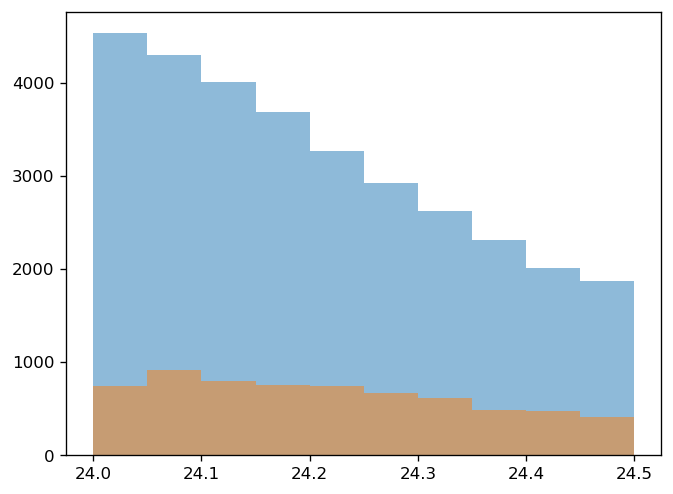

In [22]:
plt.figure(dpi = 120)
nStars = plt.hist(starRMAG, bins = np.linspace(lowerLim, upperLim, 11), alpha = 0.5)
binLims = nStars[1]
nStars = nStars[0]
nGalas = plt.hist(galaRMAG, bins = np.linspace(lowerLim, upperLim, 11), alpha = 0.5)
nGalas = nGalas[0]
plt.show()

In [23]:
starPerBin = int(np.min(nStars))
galaPerBin = int(np.min(nGalas))

In [24]:
allStarInds = np.array([])
allGalaInds = []
for i in np.arange(len(binLims) - 1):
    starInds = np.where((starRMAG >= binLims[i]) & (starRMAG <= binLims[i+1]))[0]
    np.random.shuffle(starInds)
    starInds = starInds[:starPerBin]
    allStarInds = np.append(allStarInds, starInds)
    
    galaInds = np.where((galaRMAG >= binLims[i]) & (galaRMAG <= binLims[i+1]))[0]
    np.random.permutation(galaInds)
    galaInds = galaInds[:galaPerBin]
    allGalaInds = np.append(allGalaInds, galaInds)

In [25]:
# starDET = starDET[allStarInds.astype(int)]
starPIX = starPIX[allStarInds.astype(int)]
starRMAG = starRMAG[allStarInds.astype(int)]

In [26]:
# galaDET = galaDET[allGalaInds.astype(int)]
galaPIX = galaPIX[allGalaInds.astype(int)]
galaRMAG = galaRMAG[allGalaInds.astype(int)]

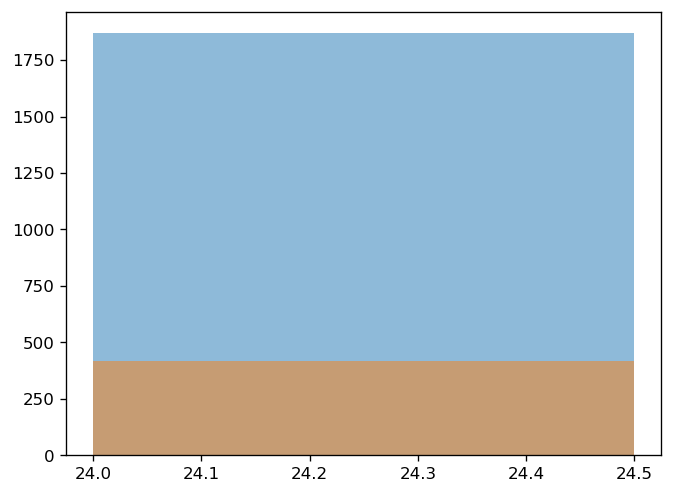

In [27]:
plt.figure(dpi = 120)
plt.hist(starRMAG, bins = binLims, alpha = 0.5)#, density = True)
plt.hist(galaRMAG, bins = binLims, alpha = 0.5)#, density = True)
plt.show()

In [28]:
# aveStar = len(starPIX) / len(np.unique(starPIX))#np.sum(starDET) / len(starDET)
# aveGala = len(galaPIX) / len(np.unique(galaPIX))#np.sum(galaDET) / len(galaDET)

In [29]:
starPixCounts = np.zeros(12*4096**2)
for pix in starPIX:
    starPixCounts[pix] += 1
starPixCounts = starPixCounts[condPix]

galaPixCounts = np.zeros(12*4096**2)
for pix in galaPIX:
    galaPixCounts[pix] += 1
galaPixCounts = galaPixCounts[condPix]

In [30]:
aveStar = np.sum(starPixCounts) / len(starPixCounts)
aveGala = np.sum(galaPixCounts) / len(galaPixCounts)

In [31]:
# conditionCheck = fitsio.read(condFiles[38])['SIGNAL']

In [32]:
# fullSkyCond = np.zeros(12*(512**2))
# fullSkyCond[validPix] = conditionCheck

In [33]:
# starCond = fullSkyCond[np.unique(starPIX)]
# galaCond = fullSkyCond[np.unique(galaPIX)]

In [34]:
xStar = np.linspace(np.average(condSignal)-3*np.std(condSignal), np.average(condSignal)+3*np.std(condSignal), numBins)
xStar = xStar[np.where(xStar <= np.max(condSignal))[0]]
xStar = xStar[np.where(xStar >= np.min(condSignal))[0]]
starSigma = sigma * np.std(condSignal)
yStar = []

for xi in xStar:
    # Gaussian weighting the values close by to each x value.
    totCor = np.sum(starPixCounts * np.exp(-1*(((condSignal - xi) / starSigma)**2)))
    totAll = np.sum(np.exp(-1*(((condSignal - xi) / starSigma)**2)))
    yStar.append((totCor / totAll) / aveStar)

yStar = np.array(yStar)

In [35]:
xGala = np.linspace(np.average(condSignal)-3*np.std(condSignal), np.average(condSignal)+3*np.std(condSignal), numBins)
xGala = xGala[np.where(xGala <= np.max(condSignal))[0]]
xGala = xGala[np.where(xGala >= np.min(condSignal))[0]]
galaSigma = sigma * np.std(condSignal)
yGala = []

for xi in xGala:
    # Gaussian weighting the values close by to each x value.
    totCor = np.sum(galaPixCounts * np.exp(-1*(((condSignal - xi) / galaSigma)**2)))
    totAll = np.sum(np.exp(-1*(((condSignal - xi) / galaSigma)**2)))
    yGala.append((totCor / totAll) / aveGala)

yGala = np.array(yGala)

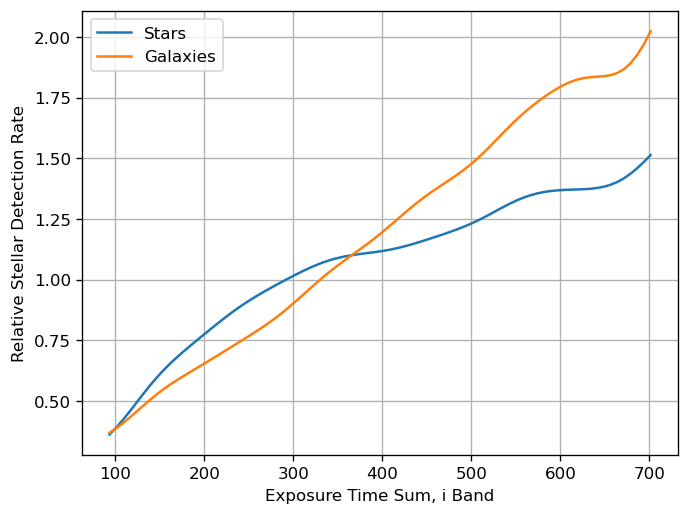

In [36]:
plt.figure(dpi = 120)
plt.plot(xStar, yStar, zorder = 3, label = 'Stars')
plt.plot(xGala, yGala, zorder = 3, label = 'Galaxies')
plt.xlabel(condition)
plt.ylabel('Relative Stellar Detection Rate')
plt.legend()
plt.grid(zorder = 0)
# plt.ylim([0, 1])
plt.show()

In [37]:
print(aveStar)
print(aveGala)

0.0007327014860518321
0.0001633885131997936
